In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

**Instruções gerais:** Sua submissão <u>deve</u> conter:
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Cross-validation

**1.** O código abaixo carrega o banco de dados *California housing*. Divida o banco de dados em treino, teste e validação. Use o conjunto de validação para escolher o coeficiente de regularização $c$ para um modelo de regressão linear com penalização $L_2$. Use a fórmula analítica para estimar os pesos do modelo de regressão. Plote os MSE no conjunto de trieno e validação em função de $c$. Comente o resultado. Avalie a performance do modelo ótimo no conjunto de teste e também comente.

In [2]:
SEED = 42
np.random.seed(SEED)

X, y = fetch_california_housing(return_X_y=True)

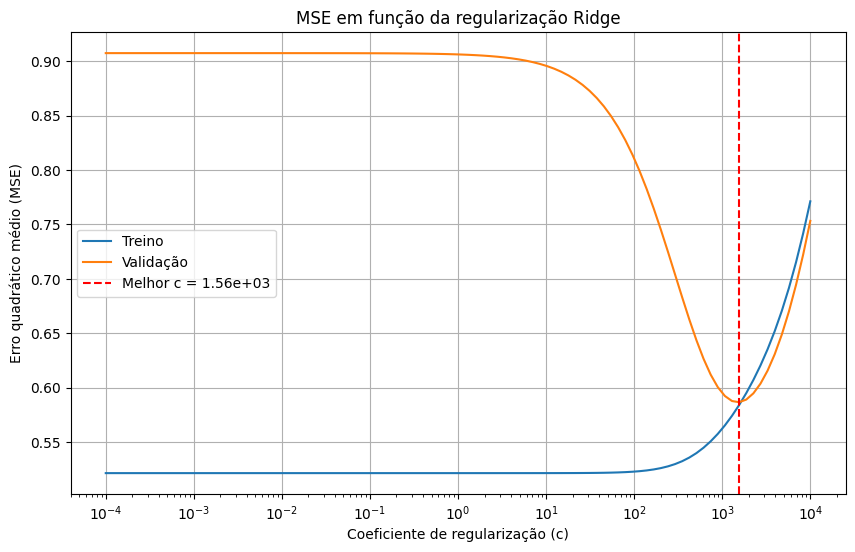

Melhor valor de c: 1555.6761
MSE no conjunto de teste com c ótimo: 0.6153


In [3]:
# Padroniza os dados (importante para regularização L2)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Divide os dados: 60% treino, 20% validação, 20% teste
n = X.shape[0]
idx = np.random.permutation(n)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

X_train, y_train = X[idx[:train_end]], y[idx[:train_end]]
X_val, y_val = X[idx[train_end:val_end]], y[idx[train_end:val_end]]
X_test, y_test = X[idx[val_end:]], y[idx[val_end:]]

# Adiciona o viés (termo constante)
def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

X_train_b = add_bias(X_train)
X_val_b = add_bias(X_val)
X_test_b = add_bias(X_test)

# Fórmula fechada para Ridge Regression: w = (X^T X + c I)^(-1) X^T y
def ridge_closed_form(X, y, c):
    n_features = X.shape[1]
    I = np.eye(n_features)
    I[0, 0] = 0  # Não penaliza o viés
    return np.linalg.inv(X.T @ X + c * I) @ X.T @ y

# Testa diferentes valores de c
c_values = np.logspace(-4, 4, 100)
mse_train = []
mse_val = []

for c in c_values:
    w = ridge_closed_form(X_train_b, y_train, c)
    y_train_pred = X_train_b @ w
    y_val_pred = X_val_b @ w
    mse_train.append(mean_squared_error(y_train, y_train_pred))
    mse_val.append(mean_squared_error(y_val, y_val_pred))

# Encontra o melhor c
best_c = c_values[np.argmin(mse_val)]

# Treina com melhor c e avalia no teste
w_best = ridge_closed_form(X_train_b, y_train, best_c)
y_test_pred = X_test_b @ w_best
mse_test = mean_squared_error(y_test, y_test_pred)

# Plot MSE vs c
plt.figure(figsize=(10, 6))
plt.plot(c_values, mse_train, label='Treino')
plt.plot(c_values, mse_val, label='Validação')
plt.axvline(best_c, color='r', linestyle='--', label=f'Melhor c = {best_c:.2e}')
plt.xscale('log')
plt.xlabel('Coeficiente de regularização (c)')
plt.ylabel('Erro quadrático médio (MSE)')
plt.title('MSE em função da regularização Ridge')
plt.legend()
plt.grid(True)
plt.show()

# Comentários
print(f"Melhor valor de c: {best_c:.4f}")
print(f"MSE no conjunto de teste com c ótimo: {mse_test:.4f}")

**2.** Implemente 5-fold *nested cross-validation* para escolher entre os métodos $k$-NN e regressão linear com regularização $L_2$ (similar ao exercício acima). Considere $k \in \{1, 2, 3, 4, 5\}$ e $c \in \{0, 1, 10, 100\}$. Use o mesmo banco de dados do último exercício e comente o resultado. Em média, qual valor de hiperparametro resulta na melhor performance para o método escolhido (use 5-fold cross validation regular para isso)?

Obs.: para simplificar sua vida, use o $k$-NN para regressão do scikit-learning com distância euclidiana.

Obs. 2: para mais informações sobre o $K$-fold *nested cross-validation*, recomendamos esses materiais:
- [Algoritmo e breve explicação](https://weina.me/nested-cross-validation): a autora apresenta uma boa explicação do assunto acompanhada de uma descrição do algoritmo;
- [Ilustrações e explicação acompanhada de código](https://ploomber.io/blog/nested-cv/): ajuda a visualizar melhor o que é *nested cross-validation*; vale lembrar que seu código, diferente do dos exemplos desse link, não deve utilizar scikit-learn para implementar a *cross-validation*.

In [4]:
SEED = 42
np.random.seed(SEED)

# Carrega e padroniza os dados
X, y = fetch_california_housing(return_X_y=True)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Adiciona viés (bias) para regressão linear
def add_bias(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

# Ridge Regression via fórmula fechada
def ridge_closed_form(X, y, c):
    n_features = X.shape[1]
    I = np.eye(n_features)
    I[0, 0] = 0  # não penaliza o viés
    return np.linalg.inv(X.T @ X + c * I) @ X.T @ y

# Previsão Ridge
def predict_ridge(X, w):
    return X @ w

# Geração de folds manualmente
def get_folds(X, y, n_folds=5):
    n = X.shape[0]
    idx = np.random.permutation(n)
    fold_sizes = (n // n_folds) * np.ones(n_folds, dtype=int)
    fold_sizes[:n % n_folds] += 1
    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_idx = idx[start:stop]
        train_idx = np.concatenate([idx[:start], idx[stop:]])
        folds.append((train_idx, val_idx))
        current = stop
    return folds

# Espaços de hiperparâmetros
c_values = [0, 1, 10, 100]
k_values = [1, 2, 3, 4, 5]

# Outer 5-fold nested CV
outer_folds = get_folds(X, y, n_folds=5)
results = []

for fold_idx, (train_val_idx, test_idx) in enumerate(outer_folds):
    X_train_val, y_train_val = X[train_val_idx], y[train_val_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    # Inner folds para escolha de hiperparâmetro
    inner_folds = get_folds(X_train_val, y_train_val, n_folds=5)

    # Avaliação de Ridge
    avg_mse_ridge = {}
    for c in c_values:
        mses = []
        for train_idx, val_idx in inner_folds:
            X_train = add_bias(X_train_val[train_idx])
            y_train = y_train_val[train_idx]
            X_val = add_bias(X_train_val[val_idx])
            y_val = y_train_val[val_idx]

            w = ridge_closed_form(X_train, y_train, c)
            y_pred = predict_ridge(X_val, w)
            mses.append(mean_squared_error(y_val, y_pred))
        avg_mse_ridge[c] = np.mean(mses)

    # Avaliação de kNN
    avg_mse_knn = {}
    for k in k_values:
        mses = []
        for train_idx, val_idx in inner_folds:
            X_train = X_train_val[train_idx]
            y_train = y_train_val[train_idx]
            X_val = X_train_val[val_idx]
            y_val = y_train_val[val_idx]

            model = KNeighborsRegressor(n_neighbors=k)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            mses.append(mean_squared_error(y_val, y_pred))
        avg_mse_knn[k] = np.mean(mses)

    # Melhor modelo entre os dois
    best_c, best_mse_ridge = min(avg_mse_ridge.items(), key=lambda x: x[1])
    best_k, best_mse_knn = min(avg_mse_knn.items(), key=lambda x: x[1])

    if best_mse_ridge < best_mse_knn:
        model_type = 'ridge'
        X_train_all = add_bias(X_train_val)
        X_test_bias = add_bias(X_test)
        w = ridge_closed_form(X_train_all, y_train_val, best_c)
        y_pred = predict_ridge(X_test_bias, w)
        test_mse = mean_squared_error(y_test, y_pred)
        best_hp = best_c
    else:
        model_type = 'knn'
        model = KNeighborsRegressor(n_neighbors=best_k)
        model.fit(X_train_val, y_train_val)
        y_pred = model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_pred)
        best_hp = best_k

    results.append({
        'fold': fold_idx + 1,
        'model': model_type,
        'hyperparam': best_hp,
        'test_mse': test_mse
    })

# Mostra os resultados por fold
for r in results:
    print(f"Fold {r['fold']}: modelo={r['model']}, hiperparâmetro={r['hyperparam']}, MSE teste={r['test_mse']:.4f}")

# Estatísticas finais
avg_mse = np.mean([r['test_mse'] for r in results])
best_model = max(set([r['model'] for r in results]), key=lambda m: sum(r['model'] == m for r in results))
print(f"\nModelo mais frequente: {best_model}")
print(f"MSE médio do modelo escolhido: {avg_mse:.4f}")

Fold 1: modelo=knn, hiperparâmetro=5, MSE teste=0.4338
Fold 2: modelo=knn, hiperparâmetro=5, MSE teste=0.4151
Fold 3: modelo=knn, hiperparâmetro=5, MSE teste=0.3973
Fold 4: modelo=knn, hiperparâmetro=5, MSE teste=0.3958
Fold 5: modelo=knn, hiperparâmetro=5, MSE teste=0.4245

Modelo mais frequente: knn
MSE médio do modelo escolhido: 0.4133


**Instruções gerais:** Sua submissão <u>deve</u> conter:
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Redes Neurais

**1.** O código abaixo baixa e carrega o banco de dados _CIFAR10_, que contém diversas imagens RGB de **10 classes distintas**. Além disso, os dados já estão separados em um objeto que provê batches de treino, teste e validação.

Também provemos um exemplo de como definir um modelo em _PyTorch_ (você é livre para modifica-lo e facilitar sua vida), bem como um exemplo de como carregar batches. **Treine uma CNN para resolver o problema --- fazendo uma busca de hiper-parâmetros razoável baseada no erro de validação.**

Eu espero uma busca de hiper-parâmetros razoável (e.g., definindo um grid de hiper-parâmetros). Eu sugiro utilizar early stopping e algum scheduler de learning rate (e.g., ReduceLROnPlateau). Como de costume em deep learning --- devido ao tamanho dos bancos ser razoável ---, não de faça coisas como cross-validation.

Consulte a documentação do _PyTorch_ para entender o que cada função na definição da CNN faz. Reporte os resultados do modelo escolhido no conjunto de teste, bem como suas curvas de aprendizado.

Além disso, mostre como os dados de entrada são transformados ao longo das camadas do modelo ótimo (plote as figuras intermerdiárias para alguns inputs da sua escolha) e comente.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm


cuda:0


100%|██████████| 170M/170M [00:03<00:00, 49.3MB/s]


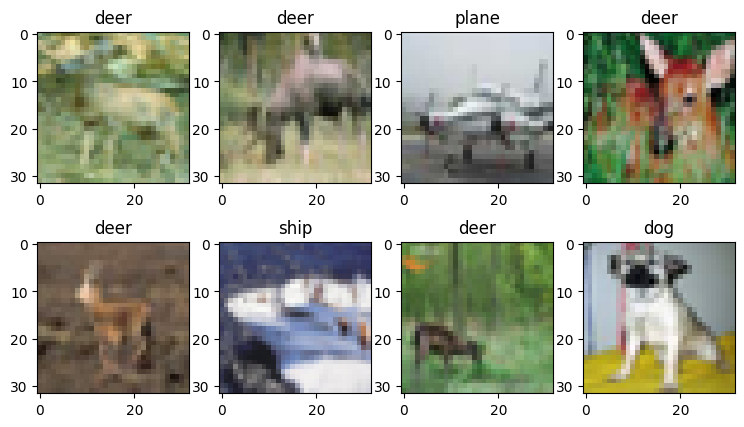

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# The batch size
batch_size = 2048

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True,
    transform=transform_train,
)
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True,
    transform=transform_test
)

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=True,
    num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

n_img = 8

f, ax = plt.subplots(2, 4, figsize=(9,5))
dataiter = iter(test_loader)
images, labels = next(dataiter)

for i in range(n_img):
    npimg = images[i]/2 + 0.5
    npimg = npimg.numpy()
    ax[i%2,i//2].imshow(np.transpose(npimg, (1, 2, 0)))
    ax[i%2,i//2].set_title(classes[labels[i]])



In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.001)


for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    aux = 0
    for data in train_loader:
        if aux == 0 and epoch == 0:
            print('this is how to load a training batch')
        aux += 1


this is how to load a training batch


In [6]:
val_ratio = 0.1
train_len = int(len(train_set) * (1 - val_ratio))
val_len = len(train_set) - train_len

train_data, val_data = random_split(train_set, [train_len, val_len])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:
# CNN com construção dinâmica
class CNN(nn.Module):
    def __init__(self, conv_channels, kernel_size, fc_sizes):
        super().__init__()

        # Camadas convolucionais
        layers = []
        in_channels = 3  # CIFAR-10: imagens RGB
        for out_channels in conv_channels:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            in_channels = out_channels
        self.conv = nn.Sequential(*layers)

        # Dummy input para calcular o tamanho da entrada da FC
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 32, 32)
            dummy_out = self.conv(dummy)
            flatten_size = dummy_out.view(1, -1).size(1)

        # Camadas totalmente conectadas
        fc_layers = []
        in_features = flatten_size
        for fc in fc_sizes:
            fc_layers.append(nn.Linear(in_features, fc))
            fc_layers.append(nn.ReLU())
            in_features = fc
        fc_layers.append(nn.Linear(in_features, 10))  # 10 classes do CIFAR-10
        self.fc = nn.Sequential(*fc_layers)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [8]:
def train_model(model, train_loader, val_loader, lr=0.001, patience=5, max_epochs=10):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=False)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model = None
    epochs_no_improve = 0

    for epoch in range(max_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # validação
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}: Train={avg_train_loss:.4f}, Val={avg_val_loss:.4f}")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping!")
                break

    model.load_state_dict(best_model)
    return model, train_losses, val_losses

In [9]:
search_space = {
    'conv_channels': [[16, 32], [32, 64]],
    'kernel_size': [3, 5],
    'fc_sizes': [[64], [128]],
    'lr': [0.001, 0.0005]
}

import itertools
configs = list(itertools.product(
    search_space['conv_channels'],
    search_space['kernel_size'],
    search_space['fc_sizes'],
    search_space['lr']
))

results = []
for conv_channels, kernel_size, fc_sizes, lr in configs:
    print(f"\nTrying config: conv={conv_channels}, kernel={kernel_size}, fc={fc_sizes}, lr={lr}")
    model = CNN(conv_channels=conv_channels, kernel_size=kernel_size, fc_sizes=fc_sizes)
    model, train_losses, val_losses = train_model(model, train_loader, val_loader, lr=lr)
    results.append({
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'config': (conv_channels, kernel_size, fc_sizes, lr),
        'val_loss': val_losses[-1]
    })

# Seleciona o melhor
best_result = min(results, key=lambda x: x['val_loss'])
best_model = best_result['model']
best_config = best_result['config']
print(f"\nMelhor configuração: {best_config}")



Trying config: conv=[16, 32], kernel=3, fc=[64], lr=0.001


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train=2.0262, Val=1.8231
Epoch 2: Train=1.7181, Val=1.6348
Epoch 3: Train=1.5611, Val=1.5170
Epoch 4: Train=1.4678, Val=1.4573
Epoch 5: Train=1.4101, Val=1.3947
Epoch 6: Train=1.3581, Val=1.3560
Epoch 7: Train=1.3149, Val=1.3186
Epoch 8: Train=1.2732, Val=1.2846
Epoch 9: Train=1.2404, Val=1.2598
Epoch 10: Train=1.2046, Val=1.2298

Trying config: conv=[16, 32], kernel=3, fc=[64], lr=0.0005
Epoch 1: Train=2.1865, Val=2.0158
Epoch 2: Train=1.8896, Val=1.7878
Epoch 3: Train=1.7205, Val=1.6598
Epoch 4: Train=1.6073, Val=1.5621
Epoch 5: Train=1.5235, Val=1.4997
Epoch 6: Train=1.4654, Val=1.4528
Epoch 7: Train=1.4247, Val=1.4157
Epoch 8: Train=1.3951, Val=1.3897
Epoch 9: Train=1.3654, Val=1.3707
Epoch 10: Train=1.3429, Val=1.3549

Trying config: conv=[16, 32], kernel=3, fc=[128], lr=0.001
Epoch 1: Train=2.0317, Val=1.8234
Epoch 2: Train=1.7306, Val=1.6425
Epoch 3: Train=1.5734, Val=1.5149
Epoch 4: Train=1.4840, Val=1.4584
Epoch 5: Train=1.4236, Val=1.4092
Epoch 6: Train=1.3695, Val=1

Acurácia no teste: 0.6133


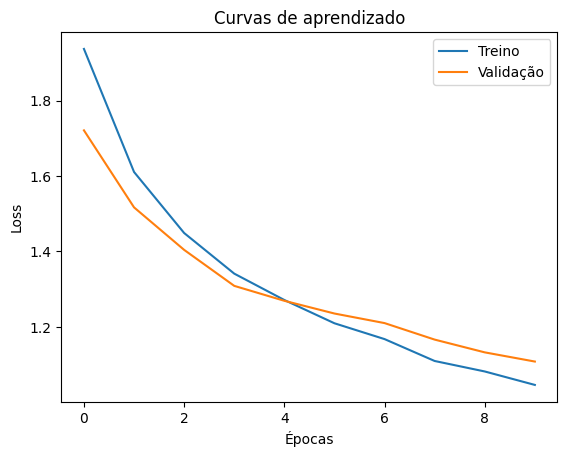

In [10]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

test_acc = evaluate(best_model, test_loader)
print(f"Acurácia no teste: {test_acc:.4f}")

# Curvas
plt.plot(best_result['train_losses'], label='Treino')
plt.plot(best_result['val_losses'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.title('Curvas de aprendizado')
plt.show()

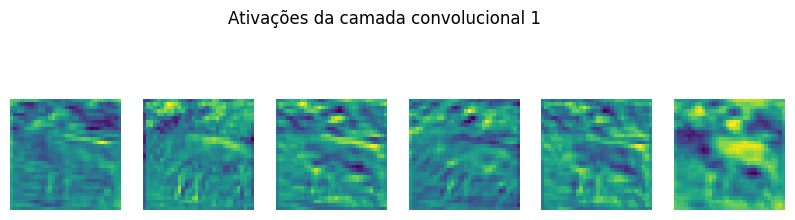

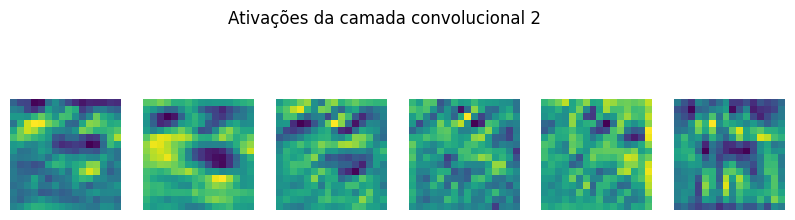

In [12]:
def show_intermediate_activations(model, input_tensor):
    import matplotlib.pyplot as plt
    import torch.nn as nn

    activations = []

    def hook_fn(module, input, output):
        activations.append(output)

    hooks = []
    # Registra hooks em todas as camadas Conv2d dentro de self.conv
    for layer in model.conv:
        if isinstance(layer, nn.Conv2d):
            hooks.append(layer.register_forward_hook(hook_fn))

    model.eval()
    with torch.no_grad():
        model(input_tensor.unsqueeze(0).to(next(model.parameters()).device))  # move o input para o mesmo device do modelo

    # Plotando as ativações
    for i, act in enumerate(activations):
        act = act.squeeze().cpu()
        plt.figure(figsize=(10, 3))
        for j in range(min(6, act.size(0))):
            plt.subplot(1, 6, j + 1)
            plt.imshow(act[j], cmap='viridis')
            plt.axis('off')
        plt.suptitle(f'Ativações da camada convolucional {i+1}')
        plt.show()

    # Remove os hooks
    for hook in hooks:
        hook.remove()


# Exemplo
sample_input = images[0]  # da primeira batch carregada
show_intermediate_activations(best_model, sample_input)

# Gaussian Processes

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns
import io
import base64

**1.** Durante a aula, discutimos como construir uma priori GP e o formato da posteriori preditiva para problemas de regressão com verossimilhança Gaussiana (com média definida pelo GP). O código abaixo cria um GP com kernel exponencial quadrático, mostra a priori preditiva e a posteriori preditiva. Experimente com o código e comente a influência de ambos os parâmetros do kernel exponencial quadrático, tanto na priori preditiva quanto na posteriori preditiva. Nos gráficos gerados, os pontos vermelhos são observações, as curvas sólidas azuis são a médias das preditivas e o sombreado denota +- um desvio padrão.

Text(0.5, 1.0, 'GP posterior')

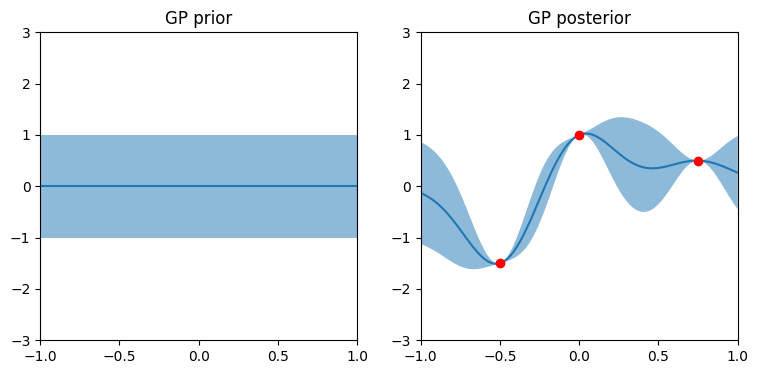

In [15]:
SEED = 42
np.random.seed(SEED)

s2 = 1e-04 # variância observacional

def rbf_kernel(x1, x2, gamma=10.0, c=1.0):
    assert(gamma>0)
    assert(c>0)
    return (-gamma*(torch.cdist(x1, x2)**2)).exp()*c

x = torch.linspace(-1, 1, 100)[:, None]

K = rbf_kernel(x, x) + torch.eye(x.shape[0])*s2
mu = torch.zeros_like(x)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].plot(x, mu)
axs[0].fill_between(x.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.5)
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-3, 3])
axs[0].set_title('GP prior')


xtrain = torch.tensor([-0.5, 0.0, 0.75])[:, None]
ytrain = torch.tensor([-1.5, 1.0, 0.5])[:, None]

def posterior_pred(x, xt, yt, gamma=10.0, c=1.0):
    Kxxt = rbf_kernel(x, xt, gamma, c)
    Kxt = rbf_kernel(xt, xt, gamma, c) + torch.eye(xt.shape[0])*s2
    Kinv = torch.linalg.inv(Kxt)
    Kxx = rbf_kernel(x, x, gamma, c)

    mu = Kxxt @ Kinv @ yt
    cov = Kxx - Kxxt @ Kinv @ Kxxt.T
    return mu, cov

post_mu, post_cov = posterior_pred(x, xtrain, ytrain)
axs[1].plot(x, post_mu)
axs[1].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
axs[1].scatter(xtrain, ytrain, color='red', zorder=5)

axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-3, 3])
axs[1].set_title('GP posterior')


##  Processo Gaussiano (GP) com Kernel RBF

Este código ilustra como um **Processo Gaussiano (GP)** com **kernel exponencial quadrático (RBF)** define distribuições sobre funções, tanto **a priori** quanto **a posteriori**, em problemas de regressão com verossimilhança Gaussiana.

A função `rbf_kernel` é controlada pelos parâmetros `gamma` e `c`, que têm papéis importantes na modelagem da função predita.

---

##  Influência dos Parâmetros do Kernel

O kernel RBF tem a forma:

\[
k(x, x') = c \cdot \exp\left(-\gamma \cdot \|x - x'\|^2\right)
\]

###  1. `gamma`: controla a largura da influência (inverso da variância)

**Baixo `gamma` (ex: 1 ou menor):**
- Kernel mais suave, funções mais "globais".
- A correlação entre pontos decresce lentamente com a distância.
- **Priori preditiva**: curvas suaves, mais largas.
- **Posteriori preditiva**: maior suavidade, maior incerteza longe dos dados observados.

**Alto `gamma` (ex: 50 ou mais):**
- Kernel mais local, funções mais "rugosas".
- Correlação entre pontos decresce rapidamente com a distância.
- **Priori**: funções com alta variação local.
- **Posteriori**: o GP se ajusta muito bem aos dados observados, mas a incerteza cresce rapidamente fora desses pontos (**overfitting**).

---

###  2. `c`: escala vertical (amplitude da função)

Afeta diretamente a variância dos valores preditos.

**Aumentar `c`:**
- Eleva a variação na função.
- **Priori**: bandas de confiança mais largas.
- **Posteriori**: mantém o mesmo ajuste aos dados, mas com mais incerteza fora dos pontos observados.

**Diminuir `c`:**
- Contrai as bandas de confiança, tornando a GP mais "conservadora".

---

##  Interpretação dos Gráficos

###  GP Prior (à esquerda)

- Mostra funções possíveis **antes de observar dados**.
- A curva azul escura é a **média (zero)**.
- A área azul clara mostra **±1 desvio padrão** (variância definida pelo kernel).
- Ajustando `gamma` e `c`, você pode controlar quão suaves ou rugosas essas funções são, e quanta variabilidade permitem.

###  GP Posterior (à direita)

- Após observar `xtrain` e `ytrain`, a GP atualiza sua crença sobre as funções possíveis.
- A curva azul sólida é a **média predita**, que passa perto dos dados observados.
- A área sombreada mostra a **incerteza** (**±1 desvio padrão**), que tende a ser menor perto dos pontos vermelhos.

---

**2.** Durante a aula, discutimos como escolher os hiper-parametros do nosso GP. Estime os parâmetros ótimos para os dados carregados abaixo (acredite, é isso que o código faz). Reporte a evidência obtida e faça um plot similar ao acima. Para o dado de teste, reporte a i) log verossimilhança e ii) o MSE com relação à média. Em caso de dúvidas, recorra a nota de aula e o link adicionado no eclass.

In [16]:
data = np.load(io.BytesIO(base64.b85decode(
    'P)h>@6aWAK2mk;8Apo$)IktlX005u^000XB6aaK`VQFq(ST1gGc>w?r0H6Z^000000D}Vn000000G-JFQ_}?;!0~YzY=9g==Y&XhJ79<?P+Lz&d|0HoP>&SM'
    '2NI?X(A<!XAf&F9gxYZsB1plJNq0ihIRZpQ_$**23=qcCzMEScGRBv|9&{@)AhLg<_iyi4)xOld$%ox21(ae|ra*E+%zB5xip_e970F;_<%;vgd{KI?I8*SS'
    '@8X}92%ftnhkr)!{KI3SqaztHTO%1?F#czrlL<L1=1>jXSP9_`ra#1EFBN&dUp#}93U`}z=Uq7W<3m;jT?g?mc%DzX*@x|yc(1GbZBQcI^|rK04V2BBL^Y+2'
    '2>OV&sD>fT|N5`c9=}Oc-;Ux)Kh#5%KK0C}5=2f&UT^G<B|Itrr%Vx`M7!#hh-(FZfcVH+w$FYOzHvTfU7#>wvZ_WXWywJL>hZevBpDQT^trs*DhO5Dx6wZ~'
    '!v-$V<-Dtd`E%k=Xs3rE#nf`py+{YH_eyu}Zl1;=a)XkTsql7Za04@Q26fwFD3`OfxLm?bo9G(@bL+s2Gth#yia`8xS&mna<{tU`x8IS%3~Ifuzle^nF1$Oq'
    '+KbUaeQpyT1dh$Edi<>I#kEak-MsA!kV)ShvPHNAZV}_Rs^}u9td17*yGFs8ad~gY_ar)B^!hCNgc^wsrl)g6fk9cRPwVpLp>u+}<>ki)l;5d}FHHXl{WZG7'
    'C;jap_g;LHbT)#a(VMt#9tJ9t)!vXuq6qn={f|sQnfIcF9an-Xxcex}zY}Csq9U0wi6sGLmP$Vj62*^s)Hnt9+sTc3wi*r;gfKt%AR%64&EI#Z8d7FHaQU@N'
    'frB|1=vY_4L7yh-ug^wd53_iglQs<lTeG<iat;hn&RT6P7JRVASl@0mg7!vvm?GPVu0}7Nrg9cDLWkVHE$fAnxT!kAuz*F65;ZZ+B$)Esds=y8P*zU@S*wFK'
    'w<vb^QyY$cXQ9a=2f&wBV0_}&4N|+@`oqK=);7=Hp|j1XuDMqk<e`D^gt6@A*VOpYsq*sTO9Z4Fo^1>!x}a9VXWtVJ<Lb(^`50#rcGzT7i~2cO`tsJoQ2aQa'
    'N(u`b=2&rY#1fFUM&Q*1;RC6!5@Yw1yXmo7=qaT7y4vhOHYq#!dE*%FTX3j)#0ZX}3~rwGKGbt4aW^j#Fnz!28|wixCgxm8jGG<AU+R5ARn<n6GToWiXp{Ia'
    'P)h>@6aWAK2mk;8Apk!*Q7DH4005u^000XB6aaK`VQFq(c`j~nc>w?r0H6Z^000000EYtr000000G*KSGaCjRfKy`8t*7DEnx=P)x;5ltqPkwS_{k~h(iOYe'
    'O?L<t%BCWTWlE8&iF)a%+|5NB+ODeRWn$XRgdeh1hY^vq1VIv~=?xX@wI;3Ezp&@q^L%_{k)NK9KC^=$Cgjn0DWYT{?HH97lzNoLpwd$L!fatuCYLYdrTo_;'
    'k}^ao+g+5Fl$EmW-u_G`gX-_YpypHmCvWQRlTzoBC(vOzFCY7KAgjDN%<$4duk3PdbIm0DDZgC&UhWh|#(pJ`*DgZi?~DzubqGv7CqC?ppGEf5&gcODRk&;S'
    '&hcASfrB($S$FR@kY=?lb<(Gib8=If@uL-N#|GT}&W>R30q<aG>0{`8IsfaOu5M&p-|t>h-hh_+8izM_D3Rsc_<o7_Dct(U@d$C!3=QvkbQpRTP*GjTUhg)d'
    'GN9TR5<P>VBG&+cUW?hxvb3mHBNCk}<wU1Z@Y)r6?}N5sP(6F>sn|OTt97sDDBr1pNp>0ITsLF<iDvt`*d9pJz8yH&Z-mG%-MjouW=M>Rjk#a<3?38&>eoZf'
    '&{rmIjyOC4H&!gSPBEW=x>BadcI?4#oQHRb_!=0WmIPe2tpQ>3cHzDwb9l<-w4-mrAX?+aI~%#(5O<|y;$+(+NTkSFyD#eS!kM~1#t3?7sN%mRuD3y4aCoux'
    '!8q88>=k7BUl9H67Y=0-4aWMYifd-Cg70`CAwAcC50l9;1I`9a=(4diTV{w;hBh51Yhc3eIlD)qg{lq<otU}+L0rw}WgcdXu?pzZ6g3h{1LFk-8&uF~KWK9;'
    '7+##?dMTqFcmHBoT$auw@4{zb;h1oxmb@O}G>841YXz;dW9Y_OQJi}*gX%it0Qt5SoL+x2*<|m4wUDAs*C#(img;=r7PSeYu7o*DLe$uj_xy&}-~uj@vWxVj'
    'X)G^x&s^R}MAP?#!2`AZxUc-+T$SAjlDi8(c{&awpWPX@*G&f1A*5@R7iNq&xUpH?G6Y-eKBS821<Y?%vKP0%S$B%3Y-__1e4JF@a<~REU%Dt*?Rwnb;9a@&'
    'wHnxLtM(DOAO6lwpHeclu;-FFotH2Ql$kZZv%GoC2`jxrXx2bq`#a}@p7#Qm^6{vaGlWM4>+XkiP57GV!8t@XVOEeqSdj7%=i4Q2d8tkCk*RUy)yNQByr~*V'
    'RM*14P)h>@6aWAK2mk;8Apn6>1aKG%001Bm000UA6aaK(b97%=E^csn0RRvHAP@im000007zzLY00000omcx~j%6R8w`g=49gOr^hM}ny%_{j!$)TvxfsiKK'
    'sKiWZBW<J_t;k_fVx=^dEEYD)XUy5mFx$-O+4<SCqeGF%dtdkG{tMpchwVAs_jO;__xt^vmOS^;u&`H}dCl;e6%Y|QeL_sYV}1dBqe21#{Q{z<#=H|Ve#&c8'
    'V<IBW_XEdIo*rp^KYh~p=t%2xw?~440{tH99_TmQ@Be(Y^0Hq|EV*^>(jI3UnSRgb-Cx??$c5J5_-`6Hu}_B=etN%={huzcE*R5D^Xd9yjr=QoTI(L|8<{sH'
    'WbKQ8H*lTxZG3S9KU}cq@VYGxe0BL}5e3N&G{64)ZUgVI7j9tvj<QZK_HN)_>#7g#XyBUD(L>jrujkC#KBdQw)YDx3Z(2QrZranT`=WZbyz8^oFHEgxsdd)}'
    '&($+4=$`$lJ?oj=uk6)hx75?zeXX{R&yJ4%q}#zdc9~>0Tt~CY?D=&p`Ed8ssgvrs@r$IAql4;bR=d`<juY3nzp-13I`-dIx_m@sE!$hG&fZnai-l8n{<x-='
    'hbw|d9-UiDv-;KXwVda*J0YNdEyvxKbk_*KT87w#@UTsf_W1FPhxKOre|Tt~c6FtPDdsWndpL7^@Z#ZPJbcl7e9S}ZA=}or^YErmKMgx_xrXNH{}k0QYi+xk'
    'UANRQIo);J@Z=gsTf3O`ZViXzn*!Ic%b7<G<@c(g+08#~YFPYt&R<>5ySdR`$W61WS!r%Y`nUW2hlOt9A(wTln`U=chPioh=#=SQdb*i6`VsH2Tije{?Q&*q'
    'HRsI8dFY1&)f_v|G_IOvw^tIY>67By)Ok`hJ?qcTdwx(gcW*NrtmdlyZ~yvz^J>Nx^?vGbMHOGLcK>%y6?<OTIl1$iD&Ev=L9^%QR<YDNMcnu*ZtLKC|M#I)'
    'w1$g$9jiFi9*9Z~8TfXM|Cvhqo3{Q@$!pfB;#O9&$drFpC4ZYezi-~?N+y{yJzB}A6>X#Z+f_2u9OrTc%_(DxDtOU6c5?;u@_S_*T2?{(=XWYNx6TY&1;<`V'
    'd~aB<3I<!Jj%`yxpS#<B``x*6di+g6%V|!3X+t?zVe)I87M3%1STCzo<s31_+*r=QH+J0nU0^v|yqCB!_vUiCtZH2HlreMh-KXw5P{ySxW`N5$#j47CiDev|'
    '_10J4PAp@m0}nr#JFtvbi%g@+SXh}o>b~Y>OuO(&{j(LNG*z0BQ_6_j&4x<Z@7~itADmN4Q?0+kOL;!zt>b>7rOX}p@SD$eETs*je_c#?J$p&YX&3Er&vMaJ'
    '@6WGYw8wImi#01wRXsD>#T+v}kGlBH?{8YIbg|*%3C}ERJj*rTottj;lrLN8#^keXCE(Lqq^ZVzhB2+}fo7MUTc27Qd4?r}?MCr)3(ft?PP4x@K>PA>r}>kG'
    'Vr%cT!1%<Hlc(6G@vA8Jic>V`ePYxp#&zA2VU>zOPZ|O_$#PxD<#7fWCpmOk<7?HopJX$;;U!GZy?K)bRZeo7gOu<d3#ENqmN38L<_EvndxG;GAMi@mM<*C!'
    'q4V(pCs-E~{>!5OoZ#xu8;)0I7t^Mv_+on78z|;B0gTZGewjt=tiho@zQILIGUN4UAwy03Hx=@tY0tDmrke5v6>=<Fnx*M;^2>eYzZ~Z-3w2g&IJ1o*wBzjg'
    'fPFBQ*+4B|a^yI}e0*k(8NdQwTWK>JH*WQ|nCuv%3T)<LdkbBCIviu3ecYp*8(^5|D1)D}nTMWnuUaiV%2gspjz~5IJHi$MJTnh1vzX!tr_|Vk%udbC5BV(g'
    '3pL2+g1!dn`FuakJoqpTd$Z+X4()jE*Ec@SWBSXt{^!mc^4QVPef%LN+QgO1Mnf-gxg2Q^)<I^QagI62ZfiDQY~6T(Usx=f_0|DiZfzR9pW#DpZt#iR&;1GJ'
    '0Q(qZ#%A0;F1OpdmtFx@*+=f>M7u0|m~XZ{d=Eno8Nlx5>Kp5=$=pqEtI4<S-NoqXX7YBi_$M=IISe&4|3nT`4LxS;q>rJM;GK*$aNM+mE{jz*Ke&T~FL|s<'
    '$Y%NjMmVw=VgrZtemuT-`+)5%GIG=J52hMg>yyP;1D~L69ApbwCfi0Dg2|xUV)4ulTe;=QRu(k3F!49@W-~`x?7G$acXnU6$*NpBFWE%Ak^2n&T>Op8PmZ-J'
    'k;Z(R=r%Aq=Ii_4*s-2IhIZ0_<_4Si*D=hLYsHUjbejhMz(qzbKUl*c1N&*;GUbK|AKkfc70+%T@ZX8+zhbC4_Tps58`_Rt%y=U+nMu4p@=NQ=dAz>T06do0'
    '?})SBh108z{U2WX9tpY*Ub+vVS_fWQ7uk9a67*d7X&*??zTnb65vqM-wa$TNIv2uqPGsxcSfn~2TXjK`>I6U44bQ8NNKjporaGfkb%&4ofKc@X(drXY)HfVf'
    'AJI&GMUeW84eC2WH3ultTp(I=0&mR?R%?zBqPar8<_wcGckt32V!7rLL7G$S)7&ClbBxPf?YYK6%{jVh?vX7VV3cryCgB8$!VUa{BV-6y2ouiW7Va=dIE1fo'
    'i8SF9Lxfwngk!`C*GLr3Q6Su-qj&&six;p}Jb@d;8weARK(urO)#4fS7VjWIJcNVdCHRV`5Fy?|ns^LXwEzZ-=de_~2bXvdf#OBPiYJjR-o!29QH&C=;(PHd'
    'n#8;4D;`Focp1mU)9@2-W3qT08RB&`7tbS1ypOM?18_?h&|5lzInoW}N=M);UBLwD4AP`KxSD3`5C%z?uv9t)mvjsFOUDo^UBfQv9B!BHVXSlzsnSJUkWM00'
    'x``y|D2k=4=q#PZH0ds~q{Hx*F5@NXG*YD7sFRLkrF0!TrSou0_u=>eIKBXmPk`ea;P?nQz5-418Ms@%1AXN~@Va~n=F6wxSNRqc$j9J{d=32Mb1+c82b1N4'
    'uvoqbTji5*M!pF*%15Dxd=<jvvoJ%x3oGTruv5MaZuvCaCf|nM@^Kg~Uxx(wJgk-PL#})v&dV3VS3VK_<QowoABhF>l}MA%M4@~quF8j^lYA-Erb<kaZ-wJy'
    'kttsbmwYZ-$oC>pJ{ZI0i{bcWIKCN<kA~x`;rMJgz8j7YhvUn!Rz4lM^6fY$ACI>3^>BPXBINrqUpWA2$^|&CoPd9n8{n@Tfx*fZn4+A4CCVMhP!54hxdcv5'
    'L7;LAhAYP)PPqo(DCc08at}PpLGV#7La=fY#wa&oj&c-Im8+1aoCPO$p`CIVpj-wgry)tX4Ni_jv2q=poCkm9J~%lLPA<eU<wQ8S5l)Uo3*|~YpqvROcOp(X'
    '6swg>;p9}*D!0PPu?SYKg_CnJSGgB!m4o5rVq8#8hOcrnoE(iP<!U4;XT!<eC{_-KlgsfxP)h>@6aWAK2mk;8ApnKqayn=a001Bm000UA6aaK(b97&ME^csn'
    '0RRvHAP@im00000Xb%7Y00000otODL6pYu#QzY9%;*q6HlD$%t@|06(AuY6^WF1>b3ME7#Yg!SNL|L+veK{CoUuK3emccN#EZJIA)Ytnjyyv&`xvq1a`#Se8'
    '_j!Ki;^}jy9BVw+c*_%QZ`s_G*CfavvO6HJLXfv}z3G0_>biyNO``4p@#9v`w`^DWEeER`wyV9uK2=o}!X8Bxf-m9!S-b}K>b6+MXW;Yee5~_^&tXkkhOa<|'
    '1!i+3Yw&nQBV`;e6~vf=L)=m<2Rj~9&#YkvoUntn23KZI#M80=gCl4pe!wf}DYn@@4sS$qq>|!N(JAL25j~DX3>bcRgQS@W5iVsJE6#c7ADL31>(>P9i#}UO'
    '31)(yfi%JTPY5n_r9Y>+B%r3iJCEY*7Z@8V&$w$+ieJAG_>vT(QEM_i_i9HZXzkiAwJ9eVv@3jH1|3a?HkpZ;ryU>gs@Jo!_42hS#xUdhoKS%KKU=>I;;#Y6'
    'YrzU4wz+WS^6Qrzv~bwA!9#Z2ND1~fTK-I4euY(EsRxt$Nf^i})^pak5U<dSRJf^Gn6~qF<01KcoRc{JNA7SsaB(qnG=}Su`#7JIz{zS1Q|(yz^Irq@D9NPF'
    'ey>B^^d~p;Rw_R3ZD-rYv>=7hS}^M910sHA;_vE;G5*F#XJSh(-tLoFE}*0$_2?7jR_iKUN<iNtg$T&;>-XlQmE)$@d&He%lhB2=?^@_a#0z2fFaG;B9}i4L'
    'tTCPbgmPc1P%ym^2|<5VBpsVEeXdqvqBS3b4&O=S`bNS7_MV@1N93UJ+sPSy!7h{tzw}@ylZrAy(-S>@C3xtZ_nv00RH(Ca|DmmtiBg@(@6>vlaQeq4-UACA'
    '$d{z^kj|Nhm7Moyhhj+hftAx3yR#6FXKa5|x1$<2$NM~7RINenD1-L}2T2elr`E1uSA)xAdfa(CYVnD8X%IS)a5`jb`KjdwoXF7?v_77Qt@ZZ)!@6YTUoXoU'
    'WtM|`#Vv~)w2F}+IPxif#2!Qgg=dq_<zYkMo!=F@tr&IRU@K{{6^Yi{8l9=h5ISGl>#~i6qGAU<OHMXpuIHDeLarKg&S_*wMrJ`etuWx&{YG5!xV~wtaWy)}'
    'KH`_tD?<Zwd#B+M5}xO5zbw#RjjeYc?aFVe#pP^6-pGGb(MQEr<3f5Ijz?*BSw^KIIUw}!{I+U*{p1iU<{TMn8uZ_U8GXWZX6(+0fFfWSSG*%hBp|>3KRX-V'
    'lc39hkdRJpfDO8GN8-6+z&WPz$imNDywEOD-Na}FOEvbl(~5MM^Rm7~lxqaGf};ufY(1#Ftv6bZpg?!*?%)T*6rfi5P#t3`U~8_8zL8E1h~maMzdkBh`KFqw'
    '8#TkdaHlhrNCy0YqoKz4>%jSsP2G1PIyjY2$ha)i;2zI~2u)uKD7PQbc@I6H;N~UM7SsiDp(z^<ST%s^Be!c;cp2b+KJV4UKTL2w{hn$}rh)nt(fGU`4JIY%'
    'e}yyK!N+WJ^A3$ps3hrh&d|GoU=^})JE;wR>2`>}Rd0a6L_ekJOEj?Ee6Wanx*iU5aa=AI>V^h3duzovDy-Ad2^FE#K<J`*Vw)BXDk9@fY!U4MjotCKdcV71'
    't}5=H=1&^TYG;nTe>4crk+vo0g(&dY)s&H%MuW&2+fZI%8Z-wc9hP`Xf!Y0}z}F)*$OuSCo#CcKhK*xQOI{C@2B+tf#!8`C%D!Z5Lle0BXGjT;H9}a5W=Em{'
    '9hmHO0k$%Y!0KI@E7+R|$)Wza+d5jHYhH26TCWM7OLL0kakfCfIdLK8N+F165BlUYy5MZ_{HO4O8ek?GA2ALf!6YM?%^{HwYzM)64`OoQtYAyPvQRvz*%{8i'
    '6fXk>?IJtr&}5kVdc5pq799rLYIX(iXJNy$U)%-1L%}JqN6EDP6I9$>*>^U#9yXnJ>rdd!hl9Q9cdKRVA!i8^m2)G2r`L1iQL#$+Xh8PArbB~T+L7kyoF_1^'
    'OsNT8B7u(1j&IV>szFp%H<y@Iij_Ldu?@vJP`7>ffZkXewAXDMtemTXlZ3hfi>VjjB`V;cOlbzDYyb1Tb7e4S(VOBxZ-j{Qn@!9M%|Jc4QSJDpd}vQ4rkPYy'
    ';lCpRiK)bLxYM7q)#P9?s9SOcD;tsEF(HIDD$)Y(@2{J2f2D$($6FP<#wNI?9NBwSsT<m3U86Nrx`6E{FGRdVg*Jowp&e;V$bDUHe*fbj7yx~KV4)l02<zrv'
    'NA$pVVj!`2g#wnFgX}JB?t|<*FXc_N`yqE%JbSm$5XcqpX|cM?0-{o4y-~<8)aaXZx!a6Gfv-zh-jgB7NH)%Lb{mGvI>V8!F)aAL*@W8XGYXX_M{Ke!KSNBK'
    'zO=FH5FC(fYDj%I3Ww8necKZ|0b$Y>E0v$8!2BDl%1~wsq&Mj74*W0$?>-(J+WmYIUSWh-fX@s>w^<16>6nG_&FRD>@;GGd{n@IsaSqgt7jBFQe*s^KpNbD)'
    '2DaK*tbE8A2gUPA2N@Alus1dP4RK-tisNMjx4i!XTF3Rb^^j*E#<riAe|28}QqqrOp|h~8!yL~zH4n``AzC6yi?HF@e)4adIas*2&+~4|JXAPlJ^rpY3+tl7'
    '!Y|A&f@?bU$TEE%m{Or<o!`zvyVUaC_Qlmb<du3ct3`OSXrxL`orgn|D!mo^8K_zmKP$-p6{e+FVO>w=!J?Q`Ql()5w974>(o1I{!H-&6PMw7hcZ}5>{O2IJ'
    '&6Z=LZyth$xzd9K=787R`C5+X6fCUmeIa5r3y--<@}32*>S`L+Ichlr4OTMU<IHIYGv|qVkvR^0n>uMf-Nqo(_r>=ILK7fb)nt{aJ^|N9+-?NtO+aA!O62Y3'
    'afo-%j$L^>1qtT+lgT&=GhW9Ag_g$Qd#n1x?3--J8PFhfDvpEljMCJ_%?t>XsQke%(hstO>3g@|U-diBgBb1I2g*4fkB1dl;FKX)>GQ4^M*N-qXutbl*wHvL'
    'E|CGH_TI$}jr3K0%p>OHZr~2oaR$Q<Fh6m0K~k0q7P4Y4W$x9$<L<*$fAj&?a10ZbU#r7)lVh4sZOdR^n`;KBwWDP<kJ9axT5Ryt%2C5wWC#Cq+M9^@Wa!~-'
    'FYX?ELACum{qi0DCvg1f(N|UI|M0!WjescBuhZ1}N2mtPMQzS)Unb+74a&LObMldv&a6Hj-i?38jE?H^uyBIw)y8}NJ!m$1t9ota0Pa2+2C@&Cxb!p3l+R-b'
    'nMZn$US##)gDWkAJuZEy(YIXYzlMdsLfV2QCI`^1H)l_U-4GhaKULD@8NjG$cK5!wL#V?eyi68lqcqQKbn%Hnthw@ElzK-${+%(4N}cXUNe*3O>7+6ICNsiQ'
    '=s1e$YP1ro^Ph1@|NM5V&Jpx->I)8J4Wn>|9Lc711YhNJWS6)zF`<ax@?g;@+6SwWPfm<u$^iR$Ui>hwYltImnqs5ywi30)s9_x2>A-hfkBxCvYsBp=*l4t9'
    'U=!UiiTgMN53p3nQ0;a5@V=L$=qYbB0PjaIbeqX!C20h$mA|f-wGUx9Y0H^=%PjoC5Z{=oJBAnfzwCOd$-)gvt!gJvvG7W%>Q@Ix7G~M|i!N;+!;y=@`%T${'
    'XnuWXQ&uYrgB433XS(&_$sofjuLL^2=8|#~KGTH-&R^~LWCrofq6fF*sX-)Fa3>Yz_Tr)4!hV+%htbSOd;gy6Y}}lYnj+87LZ298x2KJrDCDlmXQecNfgL}5'
    'RsK-X(&xo`ZI>~;8(#Xe&0-jR-rOREuk<2s!~!~O>%>y;_#^6!9^@#rQB_as!PpZU?F~G7@R-o<sLJLcJbfZ)v^1N79wAb~a<WY184`N$6h}dUoGXo&$qXE}'
    'B|DWHQjoaTpyv~*6IDOnbMo_Mpq^ZvbM7HJ$_f}C-|~GB<<~C1*y7oRl5F1%g!T1!NcUG`ms|^~n-?8zNoV4##I@RDyE-u1MuiyI-HD^qjQh3PRGdxukQy~j'
    '$5%;9j+aHd(bPhY9O=-4Q?qfO&)BW<&Ln1NT`LNGeEa=gGX+ES6eaxk^kCE6q~(BNH=eGNI>))E4rkV%D)U;sYrs^<yIp=vjO6R9l)O2J+<6iY>PxA}E2S>$'
    '$Hzb&zWBK6L;ZO7_ugZ?>pJm~D|>g29Ru}?1LTb&hA`emyY+8xCq|sqWV3fuP`GT1w|9RP#%O3g8-3i3OTif<Mi&?uc&3Gtrre4ZhT)!k<qWi_sv;BCGtiA_'
    'IWAbq#6k~ab%k0M4u+3T`<BzNCeyk2@G%zhI|YefUPr~k{nB&q2>rO<j~bP!(S?gUK3{($(2EnVrd#4h+A+dA*^lxc9dC@9cuSVn;=QXwGXGxdN0BmC!;^px'
    'Jo>hFP}P%;DQg`C$DeeduC<D$kPjKv&4k?h3Mu#?OU#Q;rw@-<{?I<fL&1~MBJ+)5badu%6bmt-V~fF$!xoBlDEm=#g|*a)x|fU|6im}_%fwGpG-yZWZ2ccy'
    'qZ)KN^r6J}B^iV7oVk$|-G*zq7YDKuTe1CY?c)oT9T-cC___TS1?$A7g1h+Ikmxi#$q=c-Zn4_YZ^a+sC+{K7`pia5K1G>VI!40bip>I|Je?TV{?tLMJQ2GS'
    'W%{zZ+fY6E;JIyuwfK-=w6u3MU$1_bX0Z+wJS{!h^gB5g4HRfw1}<g-S8lLCy<`pi`y}_AJbw{-mUE_W{gsL_uh;JUw5tht!`{5Xi|@e3X<xa8NgO_Q5Zcsz'
    'H4GQi$q8F`y++$lzclr3B!akj_?r;xMo>%I8e}5T00h)Gn*8F6(RWL9Uwo|wBfg9GCGQtPjEF)2(W4oznr7{_d0GWy{@!VOjT(TbSwM#rQ3I#%d<s6{l7_aV'
    'Ti=Ll>VaR#RoYcG1N3=1zZx`BAo<tbEn;$2aHM+D$&^wJh5WI__M4jE!4g$a<zFhaPU}68&}@YAgtm`C&fV~RzvRuUh20>VvN%*@)&uEHR#c{b6TC8M=12=E'
    'fcx?Ox9mt=plUe6URr7Zm+aFY<<_?YqunPv+`0pj`Qjg4+fV?+v+I6D&h^0hN7m0q)aW2`Yi}{kP@!}xIzroy4qg|VE-9Yw0MVf4waS4M(Es7?F_+W~ku*NS'
    'jBFh+J)W;S5l4mT2^SuM;A%d;oua0d)CK<oP)h*<6ay3h000O8001EXu*W&Jg988npaTE^3jhEB0000000000fB^si004AyVQFq(ST1gGc~DCM0u%!j00008'
    '0000X06#iWD2D?80H6Z^01E&B00000000000Du9&0{{SYa$#w1UwJNWaCuNm0Rj{Q6aWAK2mk;8Apn6>1aKG%001Bm000UA0000000000004jiga-fsbY*jN'
    'Usx_~aCuNm0Rj{Q6aWAK2mk;8ApnKqayn=a001Bm000UA0000000000004ji*bx8#bY*jNUwJNWaCuNm1qJ{B000C41OVay004X;00000'
)))

train_X, train_y = data['train_X'], data['train_y']
test_X, test_y = data['test_X'], data['test_y']

Log-marginal likelihood (evidência): -21.90
Log-verossimilhança no teste: -3488091.77
MSE no teste: 0.0100


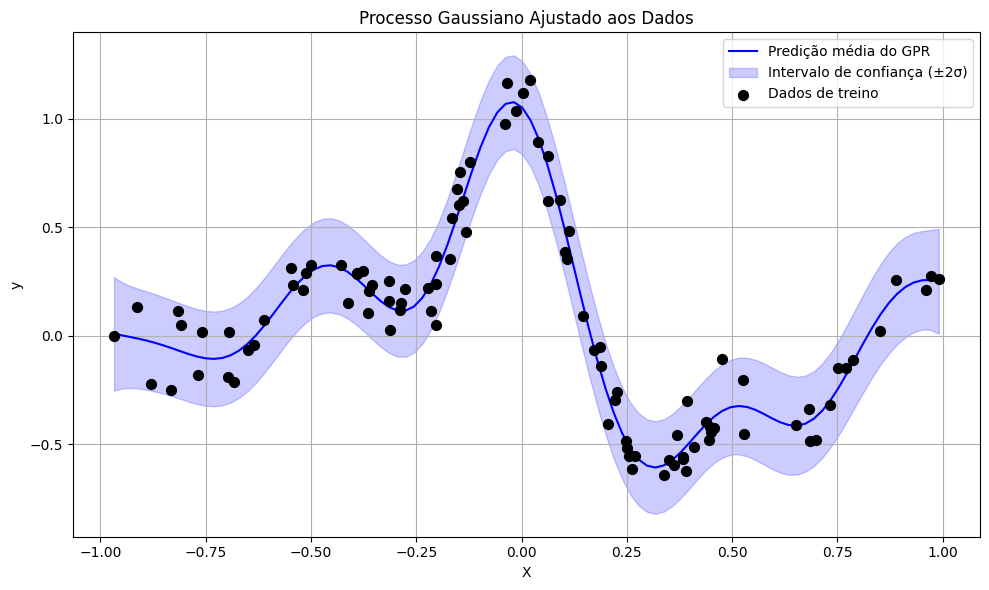

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.metrics import mean_squared_error

# 1. Usar os dados fornecidos
train_X, train_y = data['train_X'], data['train_y']
test_X, test_y = data['test_X'], data['test_y']

# 2. Definir o kernel e modelo GPR
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

# 3. Treinar o modelo com os dados de treino
gpr.fit(train_X, train_y)

# 4. Fazer predições (em um intervalo contínuo para visualização, se for 1D)
if train_X.shape[1] == 1:
    X_pred = np.linspace(train_X.min(), train_X.max(), 100).reshape(-1, 1)
    y_mean, y_std = gpr.predict(X_pred, return_std=True)
else:
    X_pred = None  # visualização só faz sentido para 1D

# 5. Calcular log-marginal likelihood (evidência)
log_marginal_likelihood = gpr.log_marginal_likelihood()
print(f"Log-marginal likelihood (evidência): {log_marginal_likelihood:.2f}")

# 6. Avaliar no conjunto de teste
y_test_pred, y_test_std = gpr.predict(test_X, return_std=True)

# Log-verossimilhança no teste
log_likelihood_test = -0.5 * np.sum(
    ((test_y - y_test_pred) ** 2) / (y_test_std ** 2) + np.log(2 * np.pi * y_test_std ** 2)
)
print(f"Log-verossimilhança no teste: {log_likelihood_test:.2f}")

# MSE no teste
mse_test = mean_squared_error(test_y, y_test_pred)
print(f"MSE no teste: {mse_test:.4f}")

# 7. Plotar se os dados forem 1D
if train_X.shape[1] == 1:
    plt.figure(figsize=(10, 6))
    plt.plot(X_pred, y_mean, 'b-', label='Predição média do GPR')
    plt.fill_between(
        X_pred.ravel(),
        y_mean - 2 * y_std,
        y_mean + 2 * y_std,
        color='blue',
        alpha=0.2,
        label='Intervalo de confiança (±2σ)'
    )
    plt.scatter(train_X, train_y, c='black', s=50, zorder=10, label='Dados de treino')
    plt.title('Processo Gaussiano Ajustado aos Dados')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Visualização não disponível: dados não são unidimensionais.")
